## アメダス

データを使う場合に重要なのはデータに関する基本的な知識です。まず気象庁ウェブサイトの「知識・解説」の中に[地域気象観測システム（アメダス）](https://www.jma.go.jp/jma/kishou/know/amedas/kaisetsu.html)を見てどのような気象要素をどこで観測しているのか確認します。アメダスの観測所一覧はCSVをZIP圧縮した形式でも提供されていますが，JSON形式で取得して地図に描いてみましょう。

### 観測所一覧

ファイルをダウンロードするPythonの標準ライブラリには[urllib.request](https://docs.python.org/3/library/urllib.request.html)がありますが，[Requests](https://docs.python-requests.org/en/master/)を使うと便利です。ダウンロードは失敗する可能性があるので，[例外](https://docs.python.org/ja/3/tutorial/errors.html)が発生する可能性があります。[with](https://docs.python.org/ja/3/reference/compound_stmts.html#the-with-statement)文を使うと，例外が発生せずURLを開けた場合にのみ，ブロック（字下げされた文のまとまり）が実行されます。返り値`as`の後の変数に格納されます。これはURLやファイルを開くときの定型の書き方です。

`requests.get()`から返されるオブジェクト`requests.Response`は`reponse`に格納されます。[オブジェクト](https://docs.python.org/ja/3/tutorial/classes.html)とはデータやデータに対するメソッド（操作）をまとめたものです。

In [1]:
import pandas as pd
import requests

url = "https://www.jma.go.jp/bosai/amedas/const/amedastable.json"
with requests.get(url) as response:
    json = response.json()
    df = pd.DataFrame(json).transpose()

In [2]:
df

,type,elems,lat,lon,alt,kjName,knName,enName
11001,C,11112010,"[45, 31.2]","[141, 56.1]",26,宗谷岬,ソウヤミサキ,Cape Soya
11016,A,11111111,"[45, 24.9]","[141, 40.7]",3,稚内,ワッカナイ,Wakkanai
11046,C,11112000,"[45, 18.3]","[141, 2.7]",65,礼文,レブン,Rebun
11061,C,11110100,"[45, 24.2]","[141, 48.1]",8,声問,コエトイ：稚内空港,Koetoi
11076,C,11112100,"[45, 20.1]","[142, 10.2]",13,浜鬼志別,ハマオニシベツ,Hamaoni-Shibetsu
...,...,...,...,...,...,...,...,...
94062,B,11111011,"[24, 25.6]","[123, 45.9]",10,西表島,イリオモテジマ,Iriomotejima Island
94081,A,11111011,"[24, 20.2]","[124, 9.8]",6,石垣島,イシガキジマ,Ishigakijima Island
94086,C,11110000,"[24, 23.7]","[124, 14.7]",31,盛山,モリヤマ：新石垣空港,Moriyama
94101,C,11112000,"[24, 15.9]","[123, 52.3]",33,大原,オオハラ,Ohara


サーバから`json()`メソッドを使うとPythonの辞書に変換されます。メソッドは`response.json()`（オブジェクトとメソッドの間にピリオド）のように呼び出します。

リストはデータを`[]`で囲みましたが，辞書は`{}`で囲みます。要素は`key:value`のようにコロンの前に値を探す手がかりとなるキーを書きます。どんなキーがあるかは`keys()`メソッドで調べることができます。`json.keys()`でキー調べると，印字された最初のキーは`"11001"`です。`json["11001"]`の値は辞書です。つまり，辞書の中に辞書が入れ子になっています。

In [3]:
json["11001"]

{'type': 'C',
 'elems': '11112010',
 'lat': [45, 31.2],
 'lon': [141, 56.1],
 'alt': 26,
 'kjName': '宗谷岬',
 'knName': 'ソウヤミサキ',
 'enName': 'Cape Soya'}

辞書から[pandas](https://pandas.pydata.org/)の`DataFrame`に変換し，`transpose()`メソッドで行と列とを入れ替えます。`DataFrame`はpanasの中心となるデータ構造で表形式のデータの列や行にラベルをつけたものです。

typeは観測点の種類で，Aは管区気象台・地方気象台・沖縄気象台，Bは測候所・特別地域気象観測所（元測候所），Cは通常のアメダス，D, E, Fはそれぞれ父島気象観測所，南鳥島気象観測所，富士山特別気象観測所を表すものと思われます。elemsは観測要素で，順に気温，降水量，風向，風速，日照時間，積雪深，湿度，気圧の有（1）無（0）に対応しているようです。日照時間の2は観測ではなく推計気象分布に基づく推定値で，2021年3月2日から気象官署・特別地域気象観測所を除く地域気象観測所において提供されています。elemsの文字列だと気象要素の有無でフィルタしにくいので，1文字ずつ別の列に分解しましょう。

In [4]:
colnames = ["temperature", "precipitation", "windDirection",
"wind", "sunshine", "snowDepth", "humidity", "pressure"]
elems_split = np.array(df["elems"].apply(list).to_list()).astype("int32")
for i in range(len(colnames)):
    df[colnames[i]] = elems_split[:, i]

緯度latと経度lonは度と分のリストになっていますので，十進法に直します。DataFrameでは辞書のように列を選択できます。

In [5]:
df["lat"] = df["lat"].str[0] + df["lat"].str[1]/60
df["lon"] = df["lon"].str[0] + df["lon"].str[1]/60

#### 散布図

アメダスの位置を散布図で描いてみましょう。pandasには，matplotlibを使ってデータを可視化する機能があります。

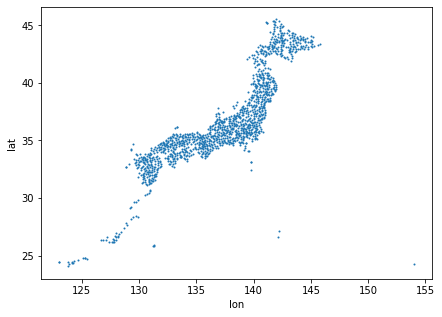

In [7]:
df.plot.scatter(x="lon", y="lat", s=1, figsize=[7,5])
plt.show()

`x`と`y`に軸の値として用いる列を指定します。`s`と`figsize`はそれぞれ点や図のサイズを調整してるだけで，必須ではありません。

アメダスは，日本全国津々浦々に展開されていることがよく分かります。

#### 最果てのアメダス

DataFrameの扱い方を練習するために最果てのアメダスを探してみます。`max()`や`min()`メソッドを使うと最大最小が求められます。列は`df.lon`のように選ぶこともできます。`loc`はラベルに基づいた行の選択を行いますが，真偽値を用いることもできます。経度が最大，つまり最東端のアメダスを表示するには次のようにします。

In [8]:
df.loc[df.lon==df.lon.max(), ["kjName", "lon", "lat"]]

,kjName,lon,lat
44356,南鳥島,153.983333,24.288333


ここでは，列を観測所の名前，経度，緯度に絞っています。

#### 練習

最も東，西，南のアメダスを探して地図に表示してください。

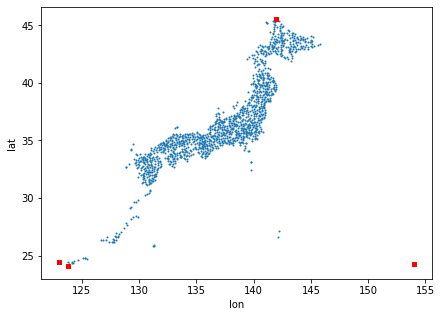

In [11]:
ax = df.plot.scatter(x="lon", y="lat", s=1, figsize=[7,5])
df.loc[(df.lon==df.lon.min()) | (df.lon==df.lon.max()) |
       (df.lat==df.lat.min()) | (df.lat==df.lat.max())].plot.scatter(
        x="lon", y="lat", s=20, c="red", marker="s", ax=ax)
plt.show()

重ねて絵を描くには，最初の図の返り値（`Axes`オブジェクト）を変数`ax`に格納し，次のプロットで`ax`を指定します。

### アメダスデータ

最新のアメダス観測データを使って，pandasに慣れていきましょう。

#### 最新の観測時刻の取得

まず，最新の観測時刻を取得します。

In [12]:
url = "https://www.jma.go.jp/bosai/amedas/data/latest_time.txt"
requests.get(url).text

'2021-08-18T16:30:00+09:00'

のようにISO形式YYYY-mm-ddTHH:MM+09:00になっています。最新データ観測時刻を取得して，データのあるURLに使うYYYYmmddHHMMという形式に変換する関数を作ります。ISO形式に基づいて日付と時刻としてパース（解釈）し`datetime`形式に変換した後，`strftime()`メソッドで整形出力しています。

In [13]:
import requests
from datetime import datetime


def get_latest():
    url = "https://www.jma.go.jp/bosai/amedas/data/latest_time.txt"
    with requests.get(url) as response:
        return datetime.fromisoformat(response.text).strftime("%Y%m%d%H%M")

#### 最新の観測データの取得

データを取得してDataFrameに格納します。

In [14]:
latest = get_latest()
url = "https://www.jma.go.jp/bosai/amedas/data/map/" + latest + "00.json"

with requests.get(url) as response:
    json = response.json()
df_amedas = pd.DataFrame(json).transpose()

#### 前処理

データ列は値と品質フラグのリストになっているので，値を表す最初の要素を残します。また`dropna()`メソッドでNaNを取り除きます。

In [15]:
for col in df_amedas.columns:
    df_amedas[col] = df_amedas[col].dropna().str[0].dropna()

観測点の経度と緯度を観測所一覧から追加します。


In [16]:
df_amedas["lon"] = df.loc[df_amedas.index, "lon"]
df_amedas["lat"] = df.loc[df_amedas.index, "lat"]

#### データの可視化

`describe()`メソッドを使うと，統計量（データ数，平均，標準偏差，最小，四分位数，最大）を表示します。また，`hist()`メソッドを呼ぶと，ヒストグラムで分布を確認することができます。

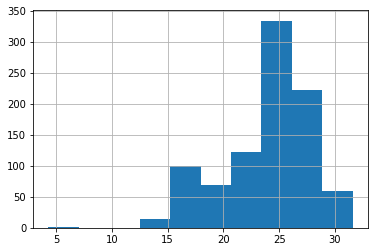

In [17]:
df_amedas["temp"].hist()
plt.show()

気温の空間分布を表示するには，`plot.scatter()`メソッドを用います。`c`に`"temp"`を渡して`cmap`に好みのカラーマップを指定します。

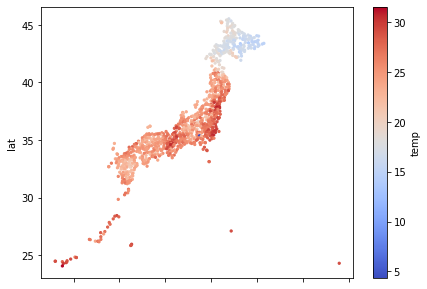

In [18]:
df_amedas.plot.scatter(x="lon", y="lat", c="temp",
    s=5, cmap="coolwarm", figsize=[7,5])
plt.show()

## 週間天気予報

この節では，JSON形式で府県週間天気予報を取得してpandasの`DataFrame`にまとめてみましょう。まず，予報区の一覧をJSON形式で取得して辞書を作ります。

In [19]:
import requests


url = "http://www.jma.go.jp/bosai/common/const/area.json"
with requests.get(url) as response:
    area = response.json()

ここでは都府県（北海道は支庁，鹿児島県奄美地方と沖縄県は地方）を`area`の中から探します。キーから値ではなく，値からキーを探します。リスト内包表記を使うと短く書けます。

`items()`メソッドでキー`k`と値`v`を一つずつ取り出します。`if`の条件に合う`k`をリストの要素とします。リストではなく単一の要素が必要なので，`[0]`をつけて最初の要素を取り出しています。このキーを使ってJSON形式の予報を取得し辞書に格納します。

In [20]:
pref_code = [k for k, v in area["offices"].items() if v["name"] == "千葉県"][0]
url = f"https://www.jma.go.jp/bosai/forecast/data/forecast/{pref_code}.json"
with requests.get(url) as response:
    forecast = response.json()

予報に含まれる天気予報文はコードとして入っています。コードに対応する予報文は[天気予報](https://www.jma.go.jp/bosai/forecast/)のページのJavaScriptの中にあります。JavaScriptの該当部分からコードと予報文を対応させる辞書を作りました。

In [ ]:
import json


TELOPS = {100:["100.svg","500.svg","100","晴","CLEAR"],（中略）, ...}

wc_dict = {k:v[3] for k, v in TELOPS.items()}
with open("weather_codes.txt", "w") as outfile:
    json.dump(wc_dict, outfile)

あらかじめJSON形式に変換したので，[json](https://docs.python.org/3/library/json.html)ライブラリの`load()`メソッドで読んでください。

In [21]:
import json


with open("weather_codes.txt", "r") as infile:
    wc_dict = json.load(infile)

それでは予報から府県週間予報を切り出します。府県週間予報は，0から最初で次の1番目にあります。そのうちキー`"areas"`に信頼度，雨の確率，天気コードが入っています。時刻はISO形式なのでPythonの`datetime`形式に変換して，DataFrameのインデックスとしました。DataFrameを使わずに，取り出したリストを活用することもできます。

In [22]:
from datetime import datetime
import pandas as pd

f1 = forecast[1]["timeSeries"][0]
wf = f1["areas"][0]
reliabilities = wf["reliabilities"]
pops = wf["pops"]
weather_codes = wf["weatherCodes"]
weather = [wc_dict[wc] for wc in weather_codes]
valid = [datetime.fromisoformat(d) for d in f1["timeDefines"]]
pd.DataFrame({"weather":weather, "reliabilities":reliabilities, "pops":pops},
             index=valid)

,weather,reliabilities,pops
2021-08-19 00:00:00+09:00,曇時々晴,,
2021-08-20 00:00:00+09:00,曇時々晴,,30
2021-08-21 00:00:00+09:00,曇時々晴,A,30
2021-08-22 00:00:00+09:00,曇時々晴,C,30
2021-08-23 00:00:00+09:00,曇時々晴,C,30
2021-08-24 00:00:00+09:00,曇時々晴,A,30
2021-08-25 00:00:00+09:00,曇時々晴,A,30
